In [117]:
import pandas as pd
import requests
import json
import matplotlib.pyplot as plt
from sklearn import linear_model


In [118]:
app_id = 104890

In [127]:
def get_cost_data(application_id):
    
    api_url = "https://cre.ally.corp/api/cost/v2/applications/" + str(application_id) +"?granularity=MONTHLY&timePeriodStart=2022-01-01&timePeriodEnd=2022-10-01"
    response = requests.get(api_url, verify=False)
    return response.json()
get_cost_data(app_id)

/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cre.ally.corp'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


{'resultsByTime': [{'estimated': False,
   'timePeriod': {'end': '2022-02-01', 'start': '2022-01-01'},
   'total': '407.36'},
  {'estimated': False,
   'timePeriod': {'end': '2022-03-01', 'start': '2022-02-01'},
   'total': '1070.47'},
  {'estimated': False,
   'timePeriod': {'end': '2022-04-01', 'start': '2022-03-01'},
   'total': '2341.53'},
  {'estimated': False,
   'timePeriod': {'end': '2022-05-01', 'start': '2022-04-01'},
   'total': '2120.64'},
  {'estimated': False,
   'timePeriod': {'end': '2022-06-01', 'start': '2022-05-01'},
   'total': '2876.44'},
  {'estimated': False,
   'timePeriod': {'end': '2022-07-01', 'start': '2022-06-01'},
   'total': '4667.05'},
  {'estimated': False,
   'timePeriod': {'end': '2022-08-01', 'start': '2022-07-01'},
   'total': '4723.46'},
  {'estimated': False,
   'timePeriod': {'end': '2022-09-01', 'start': '2022-08-01'},
   'total': '5350.52'},
  {'estimated': False,
   'timePeriod': {'end': '2022-10-01', 'start': '2022-09-01'},
   'total': '5896.

In [120]:
def get_dataframe(application_id):
    df = pd.DataFrame.from_dict(get_cost_data(application_id).get('resultsByTime'))
    df = pd.concat([df.drop(['timePeriod'], axis=1), df['timePeriod'].apply(pd.Series)], axis=1)
    df = df.drop(['estimated'], axis=1)
    df = df[['start', 'end', 'total']]
    
    return df

get_dataframe(app_id).head()

/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cre.ally.corp'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


start         end    total
0  2022-01-01  2022-02-01   407.36
1  2022-02-01  2022-03-01  1070.47
2  2022-03-01  2022-04-01  2341.53
3  2022-04-01  2022-05-01  2120.64
4  2022-05-01  2022-06-01  2876.44

In [121]:
def apply_aws_data(df: pd.DataFrame, application_id: int):
    aws_data = pd.read_csv('lambda_data.csv')
    new_df = pd.merge(aws_data, df,  how='left', left_on=['start','end'], right_on = ['start','end'])
    
    return new_df.query('application_id == app_id'.replace('app_id', str(application_id)))

apply_aws_data(get_dataframe(app_id), app_id).head()

/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cre.ally.corp'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


application_id       start         end  invocations  dynamodb_table_size  \
9           104890  2022-09-01  2022-10-01     31800000                 5.78   
10          104890  2022-08-01  2022-09-01     35000000                 5.72   
11          104890  2022-07-01  2022-08-01     32800000                 5.63   
12          104890  2022-06-01  2022-07-01     38900000                 5.02   
13          104890  2022-05-01  2022-06-01     36800000                 3.68   

    dynamodb_item_count  dynamodb_rcu  elasticsearch_requests    total  
9                  9.32          51.0                       0  5896.27  
10                 9.23          50.3                       0  5350.52  
11                 9.08          37.7                       0  4723.46  
12                 8.21          36.5                       0  4667.05  
13                 6.20          24.7                       0  2876.44

/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cre.ally.corp'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


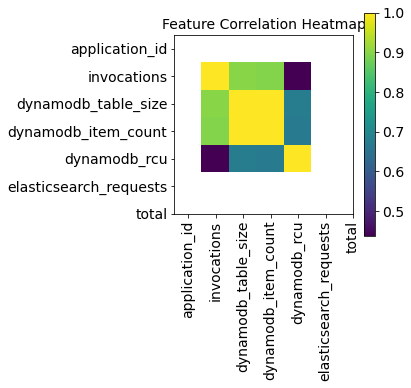

In [122]:
def show_heatmap(data: pd.DataFrame):
    plt.matshow(data.corr())
    plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=90)
    plt.gca().xaxis.tick_bottom()
    plt.yticks(range(data.shape[1]), data.columns, fontsize=14)

    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title("Feature Correlation Heatmap", fontsize=14)
    plt.show()


show_heatmap(apply_aws_data(get_dataframe(app_id), app_id).drop(['start', 'end'], axis=1))

In [125]:
from sklearn import preprocessing as pre
from sklearn.ensemble import AdaBoostRegressor

def do_regression(df: pd.DataFrame):
    # X = df[df.columns.difference(['total'])]
    X= df[['invocations', 'dynamodb_table_size', 'dynamodb_item_count', 'dynamodb_rcu', 'elasticsearch_requests']]
    y = df['total']
    scaler = pre.StandardScaler()
    X_train_scaled = scaler.fit_transform(X)

    regr = linear_model.LinearRegression(positive=True)
    regr.fit(X, y)

    regr_ardr = linear_model.ARDRegression()
    regr_ardr.fit(X, y)

    mdl_adaboost = AdaBoostRegressor(n_estimators=500, learning_rate=0.05)
    mdl_adaboost.fit(X, y)

    to_predict = [61800000,10.78,18.32,100.0,0]

    predicted_cost = regr.predict([to_predict])
    regr_predict = regr_ardr.predict([to_predict])
    pred = mdl_adaboost.predict([to_predict])

    print("predicted_cost", predicted_cost)
    print("pred", pred)
    print("regr_pred", regr_predict)

do_regression(apply_aws_data(get_dataframe(app_id), app_id))

/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cre.ally.corp'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


predicted_cost [10952.0241405]
pred [5350.52]
regr_pred [10741.74806524]
